<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-AndrewJaffray/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [45]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [46]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    # TODO: define the transformation for the test set (without any data augmentation)
    test_transform = transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize(mean=mean, std=std)
   ])

   if augmentation:
       # define the transformation for the train set (with data augmentation)
       train_transform = transforms.Compose([
           transforms.RandomHorizontalFlip(),
           transforms.RandomRotation(10),
           transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
           transforms.ToTensor(),
           transforms.Normalize(mean=mean, std=std)
       ])
       return train_transform, test_transform

   return test_transform, test_transform

## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [47]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
   """
   return train_loader, test_loader
   """

   train_transform, test_transform = getTransforms(augmentation)

   # download the FashionMNIST dataset
   train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
   test_dataset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

   # creating the data loaders
   train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
   test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

   return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Train set size: 60000
Test set size: 10000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [48]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization
        # TODO: Build a sample CNN architecture (refer architecture from week 6 exercise notebook if needed)
        # Note that the FashionMNIST dataset has 10 classes, input size of 28x28 and 1 channel (greyscale)
        # self.conv1 =
        # self.conv2 =
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2) # Remember that a kernel size and stride of 2 each effectively halves the size of the image!

        if self.useRegularization:
            self.dropout = nn.Dropout(dropout_prob)

            # self.dropout =

        # self.conv3 =
        # self.conv4 =
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)




        # self.fc1 =   # size of image after two pools i.e., 28x28 => ? => ?
        # self.fc2 =

    def forward(self, x):
        # shape x: (batch,3,32,32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch,64,16,16)

        # Use regularisation layers as you see fit

      if self.useRegularization:
           x = self.dropout(x)

       x = F.relu(self.conv3(x))
       x = F.relu(self.conv4(x))
       x = self.pool(x)

       if self.useRegularization:
           x = self.dropout(x)

       x = x.view(x.size(0), -1)

       x = F.relu(self.fc1(x))

       if self.useRegularization:
           x = self.dropout(x)

       out = self.fc2(x)
       return out

## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [49]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [50]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [51]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.301123  [   64/60000]
loss: 0.487209  [ 6464/60000]
loss: 0.272465  [12864/60000]
loss: 0.438166  [19264/60000]
loss: 0.511248  [25664/60000]
loss: 0.282222  [32064/60000]
loss: 0.283647  [38464/60000]
loss: 0.376934  [44864/60000]
loss: 0.347795  [51264/60000]
loss: 0.227055  [57664/60000]


Epochs:  20%|██        | 1/5 [00:31<02:07, 31.90s/it]

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.217492 

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.252005 

Epoch 2:

loss: 0.378786  [   64/60000]
loss: 0.146578  [ 6464/60000]
loss: 0.259850  [12864/60000]
loss: 0.250359  [19264/60000]
loss: 0.200920  [25664/60000]
loss: 0.285760  [32064/60000]
loss: 0.269156  [38464/60000]
loss: 0.136277  [44864/60000]
loss: 0.161578  [51264/60000]
loss: 0.208659  [57664/60000]


Epochs:  40%|████      | 2/5 [01:03<01:34, 31.54s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.173351 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.230159 

Epoch 3:

loss: 0.197860  [   64/60000]
loss: 0.057005  [ 6464/60000]
loss: 0.245143  [12864/60000]
loss: 0.145753  [19264/60000]
loss: 0.170802  [25664/60000]
loss: 0.257203  [32064/60000]
loss: 0.146713  [38464/60000]
loss: 0.138475  [44864/60000]
loss: 0.256860  [51264/60000]
loss: 0.169315  [57664/60000]


Epochs:  60%|██████    | 3/5 [01:34<01:02, 31.48s/it]

Train Error: 
 Accuracy: 95.3%, Avg loss: 0.126769 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.208201 

Epoch 4:

loss: 0.116774  [   64/60000]
loss: 0.117589  [ 6464/60000]
loss: 0.187787  [12864/60000]
loss: 0.231734  [19264/60000]
loss: 0.222753  [25664/60000]
loss: 0.312197  [32064/60000]
loss: 0.062493  [38464/60000]
loss: 0.224142  [44864/60000]
loss: 0.055932  [51264/60000]
loss: 0.127757  [57664/60000]


Epochs:  80%|████████  | 4/5 [02:05<00:31, 31.32s/it]

Train Error: 
 Accuracy: 95.0%, Avg loss: 0.134529 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.260355 

Epoch 5:

loss: 0.120909  [   64/60000]
loss: 0.085556  [ 6464/60000]
loss: 0.114022  [12864/60000]
loss: 0.128519  [19264/60000]
loss: 0.081658  [25664/60000]
loss: 0.063091  [32064/60000]
loss: 0.035544  [38464/60000]
loss: 0.016983  [44864/60000]
loss: 0.232880  [51264/60000]
loss: 0.047179  [57664/60000]


Epochs: 100%|██████████| 5/5 [02:36<00:00, 31.21s/it]

Train Error: 
 Accuracy: 97.6%, Avg loss: 0.066861 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.229229 

Done training!


Plotting metrics

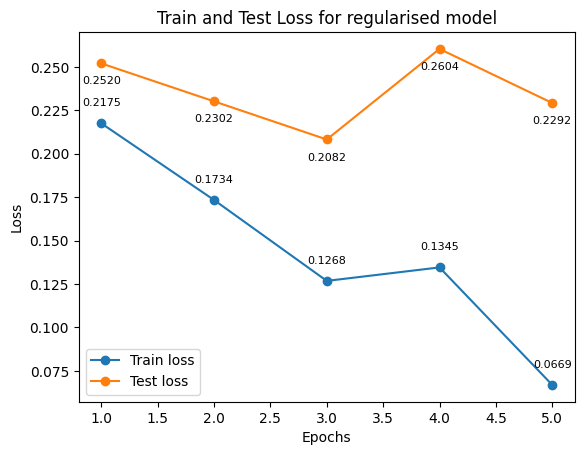

In [52]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

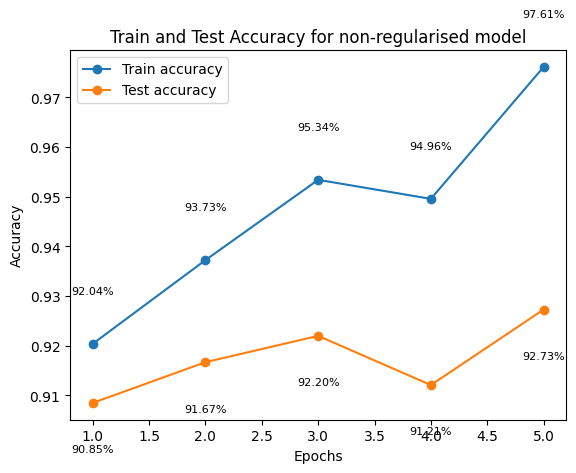

In [53]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [ ]:
# Apply only data augmentation
# train_loader, test_loader =
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)
model = NetFashion().to(device)
epochs = 5
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)


# model =
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
# optimiser =
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Plotting metrics

In [ ]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

In [ ]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [ ]:
# Apply only regularisation on the cnn model
# train_loader, test_loader =
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)
model = NetFashion(dropout_prob=0.3, useRegularization=True).to(device)

# model =
epochs = 5 # Increasing the number of epochs by 5 since the learning will be more gradual.
# optimiser =
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Plotting metrics

In [ ]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

In [ ]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [ ]:
# Apply only weight decay technique
# train_loader, test_loader =
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)
model = NetFashion(dropout_prob=0.3, useRegularization=True).to(device)


# model =
epochs = 5 # Increasing the number of epochs by 5 since the learning will be more gradual.
# optimiser =
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Plotting metrics

In [ ]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

In [ ]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [ ]:
# Apply all regularisation techniques
# train_loader, test_loader =
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)
model = NetFashion(dropout_prob=0.3, useRegularization=True).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)


# model =
epochs = 5 # Increasing the number of epochs by 5 since the learning will be more gradual.
# optimiser =
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Plotting metrics

In [ ]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

In [ ]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font color='red'>I noticed overfitting in the earlier evaluations. The model became to familiar with the training data and failed to generalize the unseen testing data. I used dropout to randomly deactivate a fraction of neurons during training and weight decay to add a penalty to large weights. These techniques improve the model's ability to handle unseen data and generalizes the data better.  </font>

